# Train a ConvNet!
We now have a generic solver and a bunch of modularized layers. It's time to put it all together, and train a ConvNet to recognize the classes in CIFAR-10. In this notebook we will walk you through training a simple two-layer ConvNet and then set you free to build the best net that you can to perform well on CIFAR-10.

Open up the file `cs231n/classifiers/convnet.py`; you will see that the `two_layer_convnet` function computes the loss and gradients for a two-layer ConvNet. Note that this function uses the "sandwich" layers defined in `cs231n/layer_utils.py`. 

In [1]:
# As usual, a bit of setup
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifier_trainer import ClassifierTrainer
from cs231n.gradient_check import eval_numerical_gradient

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
from cs231n.layers import (
    affine_forward, affine_backward,
    softmax_loss
)

from cs231n.layer_utils import (
    conv_relu_pool_forward, conv_relu_pool_backward,
)

def two_layer_convnet(X, model, y=None, reg=0.0):
    """Compute the loss and gradient for a simple two-layer ConvNet.

    The architecture is conv-relu-pool-affine-softmax, where the conv layer
    uses stride-1 "same" convolutions to preserve the input size;
    the pool layer uses non-overlapping 2x2 pooling regions.
    We use L2 regularization on both the convolutional layer weights and the
    affine layer weights.

    Inputs:
    - X: Input data, of shape (N, C, H, W)
    - model: Dictionary mapping parameter names to parameters.
      A two-layer Convnet expects the model to have the following parameters:
        - W1, b1: Weights and biases for the convolutional layer
        - W2, b2: Weights and biases for the affine layer
    - y: Vector of labels of shape (N,).
      y[i] gives the label for the point X[i].
    - reg: Regularization strength.

    Returns:
    If y is None, then returns:
    - scores: Matrix of scores, where scores[i, c] is the classification score
      for the ith input and class c.

    If y is not None, then returns a tuple of:
    - loss: Scalar value giving the loss.
    - grads: Dictionary with the same keys as model, mapping parameter names to
    their gradients.
    """

    # Unpack weights
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    N, C, H, W = X.shape

    # We assume that the convolution is "same", so that the data has the same
    # height and width after performing the convolution. We can then use the
    # size of the filter to figure out the padding.
    conv_filter_height, conv_filter_width = W1.shape[2:]
    assert conv_filter_height == conv_filter_width, (
        'Conv filter must be square'
    )
    assert conv_filter_height % 2 == 1, 'Conv filter height must be odd'
    assert conv_filter_width % 2 == 1, 'Conv filter width must be odd'
    conv_param = {'stride': 1, 'pad': (conv_filter_height - 1) / 2}
    pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

    # Compute the forward pass
    a1, cache1 = conv_relu_pool_forward(X, W1, b1, conv_param, pool_param)
    scores, cache2 = affine_forward(a1, W2, b2)

    if y is None:
        return scores

    # Compute the backward pass
    data_loss, dscores = softmax_loss(scores, y)

    # Compute the gradients using a backward pass
    da1, dW2, db2 = affine_backward(dscores, cache2)
    dX, dW1, db1 = conv_relu_pool_backward(da1, cache1)

    # Add regularization
    dW1 += reg * W1
    dW2 += reg * W2
    reg_loss = 0.5 * reg * sum(np.sum(W * W) for W in [W1, W2])

    loss = data_loss + reg_loss
    grads = {'W1': dW1, 'b1': db1, 'W2': dW2, 'b2': db2}

    return loss, grads


def init_two_layer_convnet(
    weight_scale=1e-3, bias_scale=0, input_shape=(3, 32, 32),
    num_classes=10, num_filters=32, filter_size=5
):
    """
    Initialize the weights for a two-layer ConvNet.

    Inputs:
    - weight_scale: Scale at which weights are initialized. Default 1e-3.
    - bias_scale: Scale at which biases are initialized. Default is 0.
    - input_shape: Tuple giving the input shape to the network; default is
    (3, 32, 32) for CIFAR-10.
    - num_classes: The number of classes for this network. Default is 10
    (for CIFAR-10)
    - num_filters: The number of filters to use in the convolutional layer.
    - filter_size: The width and height for convolutional filters. We assume
      that all convolutions are "same", so we pick padding to ensure that data
      has the same height and width after convolution. This means that the
      filter size must be odd.

    Returns:
    A dictionary mapping parameter names to numpy arrays containing:
    - W1, b1: Weights and biases for the convolutional layer
    - W2, b2: Weights and biases for the fully-connected layer.
    """
    C, H, W = input_shape
    assert filter_size % 2 == 1, (
        'Filter size must be odd; got %d' % filter_size
    )

    model = {}
    randn = np.random.randn
    model['W1'] = weight_scale * randn(
        num_filters, C, filter_size, filter_size
    )
    model['b1'] = bias_scale * randn(num_filters)
    model['W2'] = weight_scale * randn(num_filters * H * W / 4, num_classes)
    model['b2'] = bias_scale * randn(num_classes)
    return model


In [3]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    
    # Transpose so that channels come first
    X_train = X_train.transpose(0, 3, 1, 2).copy()
    X_val = X_val.transpose(0, 3, 1, 2).copy()
    x_test = X_test.transpose(0, 3, 1, 2).copy()

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3, 32, 32)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3, 32, 32)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


# Sanity check loss
After you build a new network, one of the first things you should do is sanity check the loss. When we use the softmax loss, we expect the loss for random weights (and no regularization) to be about `log(C)` for `C` classes. When we add regularization this should go up.

In [4]:
model = init_two_layer_convnet()

X = np.random.randn(100, 3, 32, 32)
y = np.random.randint(10, size=100)

loss, _ = two_layer_convnet(X, model, y, reg=0)

# Sanity check: Loss should be about log(10) = 2.3026
print('Sanity check loss (no regularization): ', loss)

# Sanity check: Loss should go up when you add regularization
loss, _ = two_layer_convnet(X, model, y, reg=1)
print('Sanity check loss (with regularization): ', loss)

Sanity check loss (no regularization):  2.30259705088
Sanity check loss (with regularization):  2.34509025355


# Gradient check
After the loss looks reasonable, you should always use numeric gradient checking to make sure that your backward pass is correct. When you use numeric gradient checking you should use a small amount of artifical data and a small number of neurons at each layer.

In [5]:
num_inputs = 2
input_shape = (3, 16, 16)
reg = 0.0
num_classes = 10
X = np.random.randn(num_inputs, *input_shape)
y = np.random.randint(num_classes, size=num_inputs)

model = init_two_layer_convnet(num_filters=3, filter_size=3, input_shape=input_shape)
loss, grads = two_layer_convnet(X, model, y)
for param_name in sorted(grads):
    f = lambda _: two_layer_convnet(X, model, y)[0]
    param_grad_num = eval_numerical_gradient(f, model[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 2.308053e-07
W2 max relative error: 8.429969e-06
b1 max relative error: 5.879161e-09
b2 max relative error: 1.017082e-09


# Overfit small data
A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in very high training accuracy and comparatively low validation accuracy.

In [12]:
# Use a two-layer ConvNet to overfit 50 training examples.
model = init_two_layer_convnet()
trainer = ClassifierTrainer()
best_model, loss_history, train_acc_history, val_acc_history = trainer.train(
          X_train[:50], y_train[:50], X_val, y_val, model, two_layer_convnet,
          reg=0.001, momentum=0.9, learning_rate=1e-4, batch_size=10, num_epochs=10,
          verbose=True)

starting iteration  0
Finished epoch 0 / 10: cost 2.280086, train: 0.180000, val 0.092000, lr 1.000000e-04
Finished epoch 1 / 10: cost 2.193264, train: 0.220000, val 0.126000, lr 9.500000e-05
Finished epoch 2 / 10: cost 1.557828, train: 0.260000, val 0.124000, lr 9.025000e-05
Finished epoch 3 / 10: cost 1.340603, train: 0.320000, val 0.136000, lr 8.573750e-05
Finished epoch 4 / 10: cost 1.672992, train: 0.580000, val 0.149000, lr 8.145062e-05
Finished epoch 5 / 10: cost 1.418175, train: 0.680000, val 0.162000, lr 7.737809e-05
Finished epoch 6 / 10: cost 0.575956, train: 0.780000, val 0.161000, lr 7.350919e-05
Finished epoch 7 / 10: cost 0.244489, train: 0.880000, val 0.179000, lr 6.983373e-05
Finished epoch 8 / 10: cost 0.694723, train: 0.860000, val 0.187000, lr 6.634204e-05
Finished epoch 9 / 10: cost 0.045149, train: 0.960000, val 0.188000, lr 6.302494e-05
Finished epoch 10 / 10: cost 0.235708, train: 0.880000, val 0.144000, lr 5.987369e-05
finished optimization. best validation acc

Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:

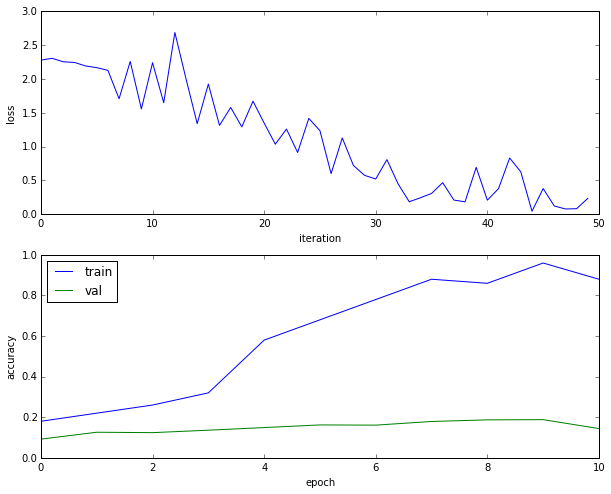

In [13]:
plt.subplot(2, 1, 1)
plt.plot(loss_history)
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

# Train the net
Once the above works, training the net is the next thing to try. You can set the `acc_frequency` parameter to change the frequency at which the training and validation set accuracies are tested. If your parameters are set properly, you should see the training and validation accuracy start to improve within a hundred iterations, and you should be able to train a reasonable model with just one epoch.

Using the parameters below you should be able to get around 50% accuracy on the validation set.

In [25]:
model = init_two_layer_convnet(filter_size=7)
trainer = ClassifierTrainer()
best_model, loss_history, train_acc_history, val_acc_history = trainer.train(
          X_train, y_train, X_val, y_val, model, two_layer_convnet,
          reg=0.001, momentum=0.9, learning_rate=1e-4, batch_size=100, num_epochs=1,
          acc_frequency=50, verbose=True)

starting iteration  0
Finished epoch 0 / 1: cost 2.299955, train: 0.109000, val 0.125000, lr 1.000000e-04
starting iteration  50
Finished epoch 0 / 1: cost 1.777689, train: 0.341000, val 0.368000, lr 1.000000e-04
starting iteration  100
Finished epoch 0 / 1: cost 1.487571, train: 0.398000, val 0.435000, lr 1.000000e-04
starting iteration  150
Finished epoch 0 / 1: cost 1.648848, train: 0.450000, val 0.449000, lr 1.000000e-04
starting iteration  200
Finished epoch 0 / 1: cost 1.486470, train: 0.455000, val 0.462000, lr 1.000000e-04
starting iteration  250
Finished epoch 0 / 1: cost 1.494823, train: 0.462000, val 0.463000, lr 1.000000e-04
starting iteration  300
Finished epoch 0 / 1: cost 1.405308, train: 0.513000, val 0.496000, lr 1.000000e-04
starting iteration  350
Finished epoch 0 / 1: cost 1.296015, train: 0.554000, val 0.540000, lr 1.000000e-04
starting iteration  400
Finished epoch 0 / 1: cost 1.322547, train: 0.537000, val 0.522000, lr 1.000000e-04
starting iteration  450
Finishe

# Visualize weights
We can visualize the convolutional weights from the first layer. If everything worked properly, these will usually be edges and blobs of various colors and orientations.

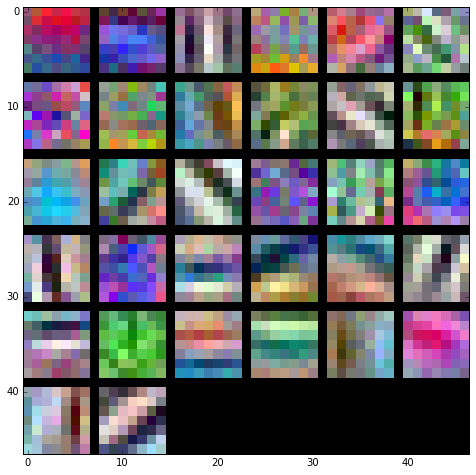

In [26]:
from cs231n.vis_utils import visualize_grid

grid = visualize_grid(best_model['W1'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))

## Testing

In [27]:
scores_test = two_layer_convnet(X_test.transpose(0, 3, 1, 2), best_model)
print('Test accuracy: ', np.mean(np.argmax(scores_test, axis=1) == y_test))

Test accuracy:  0.54
